In [6]:
from tight_binding.utilitities import compute_reciprocal_lattice_vectors_2D
from tight_binding.hamiltonians import kagome_hamiltonian_driven, kagome_hamiltonian_static, square_hamiltonian_driven, square_hamiltonian_static
from tight_binding.diagonalise import compute_time_evolution, compute_eigenstates
from tight_binding.bandstructure import compute_bandstructure2D, plot_bandstructure2D
from tight_binding.topology import compute_zak_phase, locate_dirac_strings
import numpy as np

#KAGOME
#a_1 = np.transpose(np.array([[1,0]]))
#a_2 = np.transpose(np.array([[0.5, 0.5*3**0.5]]))
#a_3 = a_2 - a_1
#r_a = a_3 / 2
#r_b = a_2 / 2
#r_c = a_1 / 2
#offsets = np.array([r_a, r_b, r_c])

#SQUARE
a_1 = np.transpose(np.array([[1,0]]))
a_2 = np.transpose(np.array([[0,1]]))
r = np.transpose(np.array([[0,0]]))
offsets = np.array([r,r,r])

H = square_hamiltonian_driven(0,1,-1,0,0,0,1,1,1,0,0,0,1,3,0,1,0)

energies, blochvectors = compute_bandstructure2D(H,a_1,a_2,100,3,100)

In [7]:
print(energies)

[[[-1.93874825  0.15564685  2.25004196]
  [-1.93048263  0.16391248  2.25830758]
  [-1.90571839  0.18867672  2.28307182]
  ...
  [-1.86455326  0.22984185  2.32423695]
  [-1.90571839  0.18867672  2.28307182]
  [-1.93048263  0.16391248  2.25830758]]

 [[-1.86576017  0.22863493  2.32303003]
  [-1.85749455  0.23690055  2.33129565]
  [-1.83273031  0.26166479  2.35605989]
  ...
  [-1.79156518  0.30282992  2.39722502]
  [-1.83273031  0.26166479  2.35605989]
  [-1.85749455  0.23690055  2.33129565]]

 [[-1.79367442  0.30072069  2.39511579]
  [-1.7854088   0.30898631  2.40338141]
  [-1.76064455  0.33375055  2.42814565]
  ...
  [-1.71947943  0.37491568  2.46931078]
  [-1.76064455  0.33375055  2.42814565]
  [-1.7854088   0.30898631  2.40338141]]

 ...

 [[-2.1602349  -0.06583979  2.02855531]
  [-2.15196928 -0.05757417  2.03682093]
  [-2.12720503 -0.03280993  2.06158517]
  ...
  [-2.08603991  0.0083552   2.1027503 ]
  [-2.12720503 -0.03280993  2.06158517]
  [-2.15196928 -0.05757417  2.03682093]]

 [

In [8]:
energies_sorted = np.zeros(energies.shape, dtype='float')
blochvectors_sorted = np.zeros(blochvectors.shape, dtype='complex')
for i in range(energies.shape[0]):
    for j in range(energies.shape[1]):
        if i == 0 and j == 0:
            current_energies = energies[i,j]
            ind = np.argsort(current_energies)
            energies_sorted[i,j] = energies[i,j, ind]
            blochvectors_sorted[i,j] = blochvectors[i,j,:,ind]
            previous_energies = current_energies[ind]
        else:
            current_energies = energies[i,j]
            ind = np.argsort(current_energies)
            differences = np.zeros((3,), dtype='float')
            for shift in range(3):
                ind_roll = np.roll(ind,shift)
                diff = (current_energies[ind_roll] - previous_energies) % (2*np.pi)
                diff = (diff + 2*np.pi*np.floor((-np.pi-diff) 
                                                / (2*np.pi) + 1))
                diff = np.abs(diff)
                diff = np.sum(diff)
                differences[shift] = diff
            minimum = np.argmin(differences)
            ind = np.roll(ind, minimum)
            energies_sorted[i,j] = energies[i,j, ind]
            blochvectors_sorted[i,j] = blochvectors[i,j,:,ind]
            previous_energies = current_energies[ind]

In [23]:
if {js:s}:
    print('yes')

NameError: name 'js' is not defined

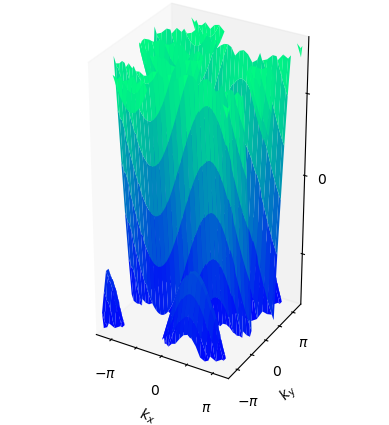

In [10]:
plot_bandstructure2D(energies_sorted, a_1, a_2, 'test.png')